In [6]:
import os
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from matplotlib import rcParams

import src as sp
import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

In [7]:
# reproducibility
#np.random.seed(0)
#pt.manual_seed(0)

In [8]:
# parameters
device = pt.device("cuda")

# model parameters
# r6
save_path = "model/save/s_v6_4_2022-09-16_11-51"  # virtual Cb & partial
#save_path = "model/save/s_v6_5_2022-09-16_11-52"  # virtual Cb, partial & noise

# r7
#save_path = "model/save/s_v7_0_2023-04-25"  # partial chain
#save_path = "model/save/s_v7_1_2023-04-25"  # partial secondary structure
#save_path = "model/save/s_v7_2_2023-04-25"  # partial chain high coverage

# create models
model = rt.SequenceModel(save_path, "model.pt", device=device)

# create confidence mapping
conf = rt.ConfidenceMap("results/{}_cdf.csv".format(os.path.basename(save_path)))

In [9]:
# parameters
pdb_filepaths = glob("examples/tem1-cplx/1JTG.pdb")  # 0.4 / 1.0 / 86.7 / 40.4

# debug 
len(pdb_filepaths)

1

In [10]:
# parameters
d_thr = 4.0
cids_sel = ['1']

# load structure
structure = rt.load_structure(pdb_filepaths[0], rm_wat=False)
key = pdb_filepaths[0]
pdbid = os.path.basename(key).split('.')[0]
structure['chain_name'] = np.array([str(cid) for cid in structure['cid']])

# molecule type and discard unclassified
subunits = sp.split_by_chain(structure)
sub_types = rt.subunits_type(subunits)
structure = sp.concatenate_chains(subunits)

# find proteins subunits and residue to chain mapping
cids_prot = [st[1] for st in sub_types if st[0] == 'protein']

# apply model on full structure
_, p, y = model(structure)

# prediction split by chain
rcids = np.array([res['chain_name'][0] for res in sp.split_by_residue(structure)])

# apply model with binder subunits known
pc, yc = {}, {}
for cid in cids_prot:
    m_known = (structure['chain_name'] != cid)
    _, pi, yi = model(structure, m_known=m_known)
    pi = pi[rcids==cid]
    yi = yi[rcids==cid]
    pi, yi = rt.aa_only(pi, yi)
    pc[cid] = pi
    yc[cid] = yi

# apply model to subunits alone
cids_prot = [st[1] for st in sub_types if st[0] == 'protein']
ps, ys = {}, {}
for cid in cids_prot:
    subunit = subunits[cid]
    subunit['chain_name'] = np.array([cid]*subunit['xyz'].shape[0])
    if len(np.unique(subunit['resid'])) >= model.module.config_data['min_num_res']:
        _, pi, yi = model(subunit)
        pi, yi = rt.aa_only(pi, yi)
        ps[cid] = pi
        ys[cid] = yi
        
# check that labels match perfectly
for cid in ys:
    assert pt.sum(pt.abs(yc[cid] - ys[cid])).long().item() == 0

# contacts
contacts = sp.extract_all_contacts(subunits, d_thr, device=device)

# analyse interface recovery
interfaces = {}
for cid in cids_sel:
    # checks
    if (cid in contacts) and (cid in ys):
        for cidb in list(contacts[cid]):
            # atom-atom contacts indices
            ctc_ids = contacts[cid][cidb]['ids'][:,0]

            # convert to residue-residue contacts indices
            _, ids = pt.unique(pt.from_numpy(subunits[cid]['resid']), return_inverse=True)
            ctc_rids = pt.unique(ids[ctc_ids])

            ids_rctc = np.argmax((subunits[cid]['resid'].reshape(-1,1) == np.unique(subunits[cid]['resid'][np.unique(ctc_ids)])).astype(float), axis=0)
            rctc_seq = np.array([sp.res3to1[rn] for rn in subunits[cid]['resname'][ids_rctc]])
            
            # binder type
            btype = [st[0] for st in sub_types if st[1] == cidb][0]

            # get predictions
            y0 = pt.max(ps[cid][ctc_rids] * ys[cid][ctc_rids], dim=1)[0].numpy()
            y1 = pt.max(pc[cid][ctc_rids] * yc[cid][ctc_rids], dim=1)[0].numpy()
            p0 = pt.max(ps[cid][ctc_rids], dim=1)[0].numpy()
            p1 = pt.max(pc[cid][ctc_rids], dim=1)[0].numpy()
            c0 = pt.max(pt.from_numpy(conf(ps[cid][ctc_rids].numpy())) * ys[cid][ctc_rids], dim=1)[0].numpy()
            c1 = pt.max(pt.from_numpy(conf(pc[cid][ctc_rids].numpy())) * yc[cid][ctc_rids], dim=1)[0].numpy()
            n0 = pt.where(pt.argsort(-ps[cid][ctc_rids], dim=1) == pt.argmax(ys[cid][ctc_rids], dim=1).unsqueeze(1))[1].numpy()
            n1 = pt.where(pt.argsort(-pc[cid][ctc_rids], dim=1) == pt.argmax(yc[cid][ctc_rids], dim=1).unsqueeze(1))[1].numpy()

            x = np.arange(y0.shape[0])
            if btype in interfaces:
                interfaces[btype][0] = np.concatenate([interfaces[btype][0], ctc_rids])
                interfaces[btype][1] = np.concatenate([interfaces[btype][1], y0])
                interfaces[btype][2] = np.concatenate([interfaces[btype][2], y1])
                interfaces[btype][3] = np.concatenate([interfaces[btype][3], p0])
                interfaces[btype][4] = np.concatenate([interfaces[btype][4], p1])
                interfaces[btype][5] = np.concatenate([interfaces[btype][5], c0])
                interfaces[btype][6] = np.concatenate([interfaces[btype][6], c1])
                interfaces[btype][7] = np.concatenate([interfaces[btype][7], n0])
                interfaces[btype][8] = np.concatenate([interfaces[btype][8], n1])
                interfaces[btype][9] = np.concatenate([interfaces[btype][9], rctc_seq])
            else:
                interfaces[btype] = [ctc_rids.numpy(), y0, y1, p0, p1, c0, c1, n0, n1, rctc_seq]

In [11]:
list(interfaces)

['protein']

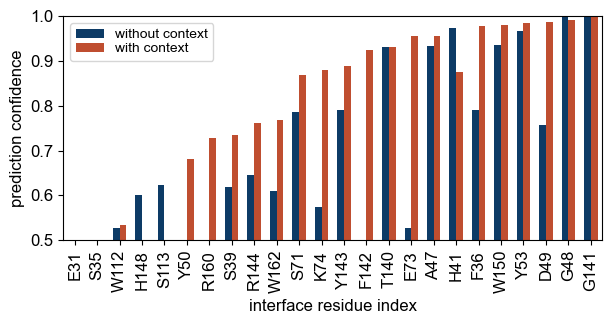

{'recovery_rate_without_context': 0.2916666666666667,
 'recovery_rate_with_context': 0.5,
 'maximum_recovery_rate_without_context': 0.7916666666666666,
 'maximum_recovery_rate_with_context': 0.8333333333333334}

In [12]:
# parameters
ws = 0.3
itype = "protein"

# extract data
v, y0, y1, p0, p1, c0, c1, n0, n1, rn = interfaces[itype]

#m0 = ((y0 < 0.5) & (y1 > 0.5)).astype(float)
#m1 = (y0 < y1).astype(float)
#ids = np.argsort(2*y1-p1 + (y1-y0) + (p1 == y1).astype(float))
ids = np.argsort(np.maximum(y0, y1))
v = v[ids]
rn = rn[ids]
y0 = y0[ids]
y1 = y1[ids]
p0 = p0[ids]
p1 = p1[ids]
n0 = n0[ids]
n1 = n1[ids]
x = np.arange(v.shape[0])

# plot
#plt.figure(figsize=(10,2.4))
#plt.figure(figsize=(3,2.4))
#plt.figure(figsize=(1+0.3*v.shape[0],2.4))
#plt.figure(figsize=(1+0.3*v.shape[0],3.4))
plt.figure(figsize=(1+0.22*v.shape[0],3.4))
#plt.bar(x-0.5*ws, p0, width=ws, color=colors[3], alpha=0.5)
plt.bar(x-0.5*ws, y0, width=ws, color=colors[1], label="without context")
#plt.bar(x+0.5*ws, p1, width=ws, color=colors[3], alpha=0.5)
plt.bar(x+0.5*ws, y1, width=ws, color=colors[0], label="with context")
#for i in range(p0.shape[0]):
#    plt.plot([x[i]-ws*0.9, x[i]-0.1*ws], [p0[i], p0[i]], 'k-', alpha=0.5)
#    plt.plot([x[i]+ws*0.1, x[i]+0.9*ws], [p1[i], p1[i]], 'k-', alpha=0.5)
#plt.plot([-0.5, len(x)-0.5], [0.5, 0.5], 'k-', alpha=0.5)
#plt.xticks(x, v+1)
plt.xticks(x, [n+str(i) for n,i in zip(rn,v+1)], fontsize=12, weight='normal', rotation=90)
plt.yticks(np.linspace(0.5, 1.0, 6), np.linspace(0.5, 1.0, 6))
plt.xlim(-0.5, len(x)-0.5)
plt.ylim(0.5, 1.0)
plt.legend(loc='best', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('interface residue index')
plt.ylabel('prediction confidence')
plt.tight_layout()
#plt.savefig("graphs/{}_{}_interface_prediction.svg".format(pdbid, itype))
plt.show()

# save statistics
summary = {
    'recovery_rate_without_context': np.mean(p0 == y0),
    'recovery_rate_with_context': np.mean(p1 == y1),
    'maximum_recovery_rate_without_context': np.mean(y0 >= 0.5),
    'maximum_recovery_rate_with_context': np.mean(y1 >= 0.5),
}
#json.dump(summary, open("results/{}_{}_interface_prediction.json".format(pdbid, itype), 'w'))
summary

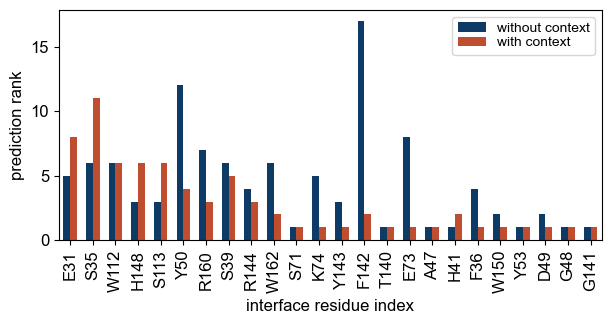

In [13]:
#plt.figure(figsize=(1+0.3*v.shape[0],3.4))
plt.figure(figsize=(1+0.22*v.shape[0],3.4))
plt.bar(x-0.5*ws, n0+1, width=ws, color=colors[1], label="without context")
plt.bar(x+0.5*ws, n1+1, width=ws, color=colors[0], label="with context")
plt.xticks(x, [n+str(i) for n,i in zip(rn,v+1)], fontsize=12, weight='normal', rotation=90)
#plt.yticks(np.linspace(0.5, 1.0, 6), np.linspace(0.5, 1.0, 6))
plt.xlim(-0.5, len(x)-0.5)
#plt.ylim(0.5, 1.0)
plt.legend(loc='best', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('interface residue index')
plt.ylabel('prediction rank')
plt.tight_layout()
#plt.savefig("graphs/{}_{}_interface_prediction_rank.svg".format(pdbid, itype))
plt.show()